In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

from scipy.ndimage.filters import maximum_filter
from scipy.ndimage.morphology import generate_binary_structure, binary_erosion 
from scipy.ndimage.morphology import iterate_structure



# Finding Local Peaks in a 2D Array

## Toy Problem

We want to find the primary points of contact made by puppy-paws on a pressure-sensor. There are 4 images that are 11x14 pixesl. 

The pressure-heatmap data is given below:

**Note that the background (in purple) corresponds to a value of 0 in the heatmap. this is the so-called "background" of the image**

In [51]:
paws = np.loadtxt('paws.txt').reshape(4, 11, 14)
print(paws.shape)

(4, 11, 14)


<IPython.core.display.Javascript object>


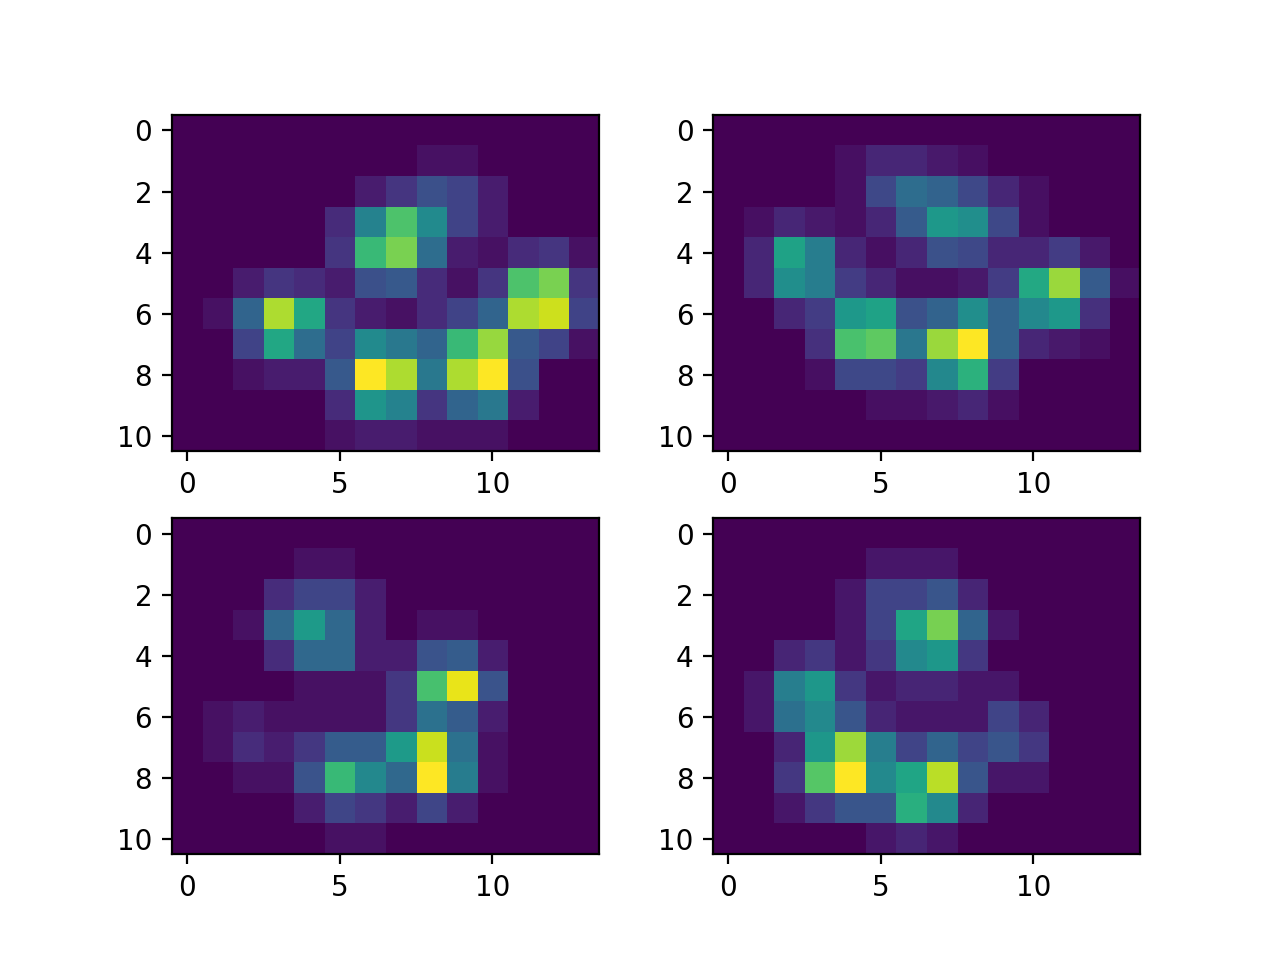

In [52]:
fig, ax = plt.subplots(nrows=2, ncols=2)
for n, (i,j) in enumerate([(0,0), (0,1), (1,0), (1,1)]):
    ax[i, j].imshow(paws[n]);

For each "toe", we want to find the pixel with the maximum pressure. This corresponds to a finding the local peaks in a 2D image. This is much more nuanced than finding the global maximum. It is also not completely well defined - we need to specify what we mean by local.

### generate_binary_structure

We will use `scipy.ndimage.morphologygenerate_binary_structure` to help us define the local neighborhood that we will consider, when looking for 2D peaks.

`generate_binary_structure` produces the footprint in which we look for neigbors. Using `generate_binary_structure(rank=2,connectivity=1)` means that, for a given pixel, we will check its two vertical and two horizontal neighbors when checking for the local maximum.


In [53]:
structure = generate_binary_structure(rank=2,connectivity=1)

Use matplotlib's `ax.imshow` to plot this 2D boolean array

<IPython.core.display.Javascript object>


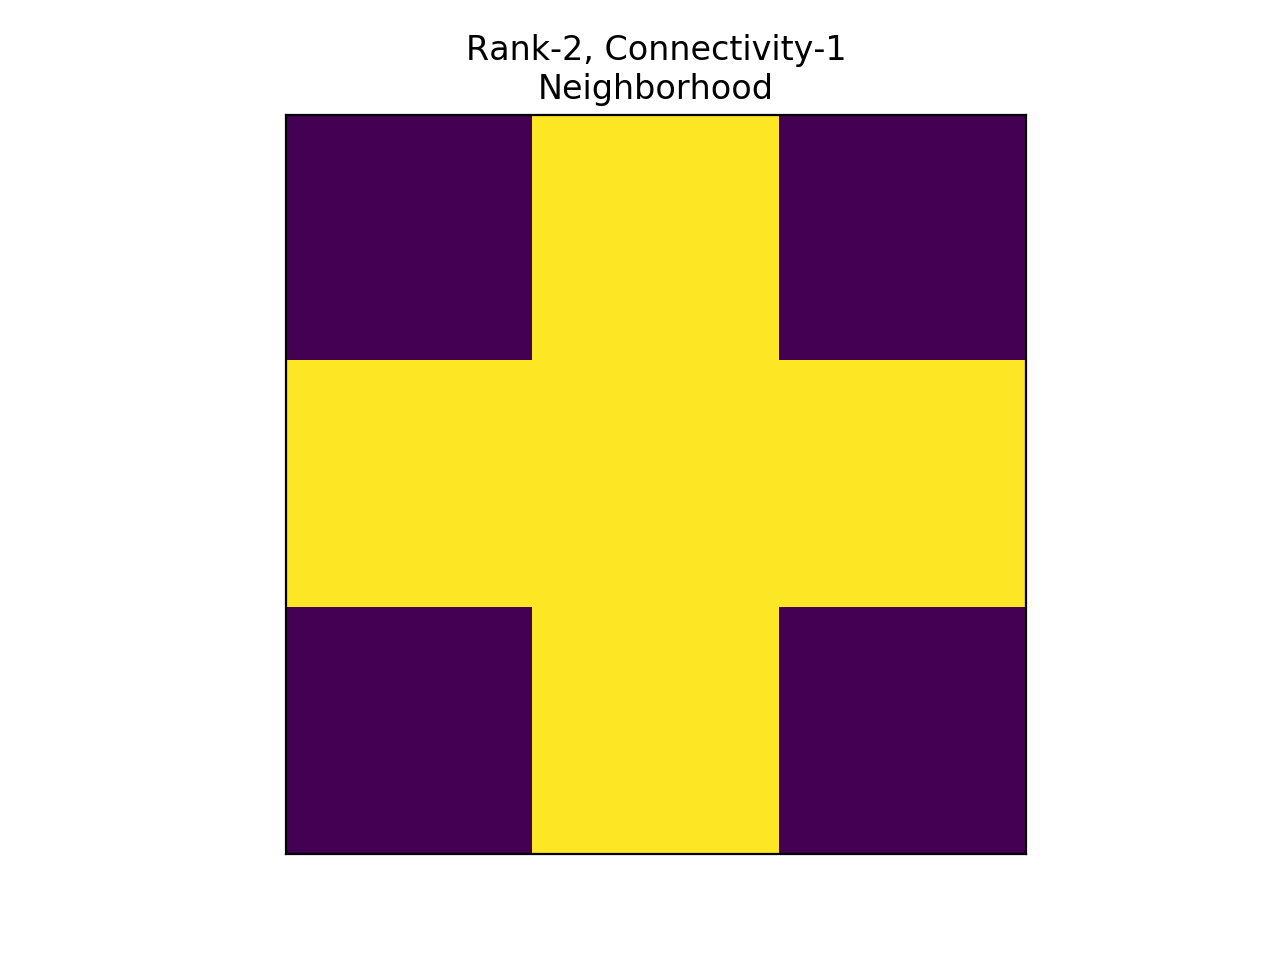

In [54]:
fig, ax = plt.subplots()
# your code here
ax.set_title("Rank-2, Connectivity-1\nNeighborhood")
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([]);
ax.imshow(structure)

What is the "footprint" produced by `generate_binary_structure(rank=2,connectivity=2)`?

Boolean arrays behave like a binary mask when multiplied with a numerical array.Meaning that `False` acts like `0`, and `True` acts like `1`.

Try multiplying the 
 - connectivity-1, rank-2 binary structure 

with 
  - a (3, 3)-shaped array of 2s. 

Try to predict what the result will be before running your code.

### maximum_filter
`scipy.ndimage.filters.maximum_filter` is able to take a binary strucure and use it to define a local "neighborhood", or "footprint" (wherever the footprint is `True`), within which it identifies the local maxima in an array. It rasters this footprint over our 2D array fith the footprint centered at each element, and produces a 2D array of the same shape, but whose elements contain the local max values.

For example, consider the array of data:
```python
data = np.array([[ 4,  0,  5],
                 [ 2,  9,  1],
                 [10, -2,  1]])
```

Given the binary foot print:
```python
fp = np.array([[False,  True, False],
               [ True,  True,  True],
               [False,  True, False]], dtype=bool)
```

Using this footprint, `maximum_filter` will look at the entry 4, above it, below it, to the left, and to the right, and will populate that position of the (3, 3) output array with the maximum in that footprint. Because there is no entry above 4, or to the left, `maximum_filter` will "mirror" the data across the boundary. This 'mode' of dealing with the boundary can be changed (see the docstring). The maximum value here is 4.

`maximum_filter` places the footprint centered at each element of the data array and populates the corresponding element of the output with the maximum value from the footprint. What will be the output of  `maximum_filter(data, footprint=fp)` be? Determine this by hand before running the code.

In [55]:
data = np.array([[ 4,  0,  5],
                 [ 2,  9,  1],
                 [10, -2,  1]])
fp = np.array([[False,  True, False],
               [ True,  True,  True],
               [False,  True, False]], dtype=bool)

print(maximum_filter(data, footprint = fp))

[[ 4  9  5]
 [10  9  9]
 [10 10  1]]


Exercise: 

Given the data array
```python
data = np.array([[ 2,   14,  10,  5],
                 [ -1,  19,   1,  4],
                 [ 10,  -2,   7,  2],
                 [  9,   8,   4,  6]])
```

Find `fp` such that

```python
>>> maximum_filter(data, footprint=fp)
array([[19, 10, 19, 10],
       [14, 10, 14, 10],
       [19,  9, 19,  6],
       [10, 10,  8,  7]])
```

Hint: Start with the four elements in the middle of the output, since the borders are trickier. Keep in mind how border cases are handled by default


In [74]:
data = np.array([[ 2,   14,  10,  5],
                 [ -1,  19,   1,  4],
                 [ 10,  -2,   7,  2],
                 [  9,   8,   4,  6]])

fp = np.array([[True, False, True],
               [False, False, False],
               [True, False, True]], dtype=bool)

print(maximum_filter(data, footprint = fp))

[[19 10 19 10]
 [14 10 14 10]
 [19  9 19  6]
 [10 10  8  7]]


What if we want to use a larger footprint than a (3, 3)-sized oned? We can make use of `scipy.ndimage.morphology.iterate_structure`. This allows us to set roughly the number of nearest neighbors (along a given direction) that that we want to included in the footprint.

For instance:
```python
>>> fp = generate_binary_structure(2,1)

# iterate_structure is imported at the top of this notebook
>>> iterate_structure(fp, 2)
array([[False, False,  True, False, False],
       [False,  True,  True,  True, False],
       [ True,  True,  True,  True,  True],
       [False,  True,  True,  True, False],
       [False, False,  True, False, False]], dtype=bool)
```

See that, the center `True` has two `True` values above, below, to the left and to the right of it. This is what we mean when we say the neighborhood includes two nearest neighbors to the center.

Plot this larger neighborhood using `ax.imshow`, given by using `iterate_structure` in the way shown above

<IPython.core.display.Javascript object>


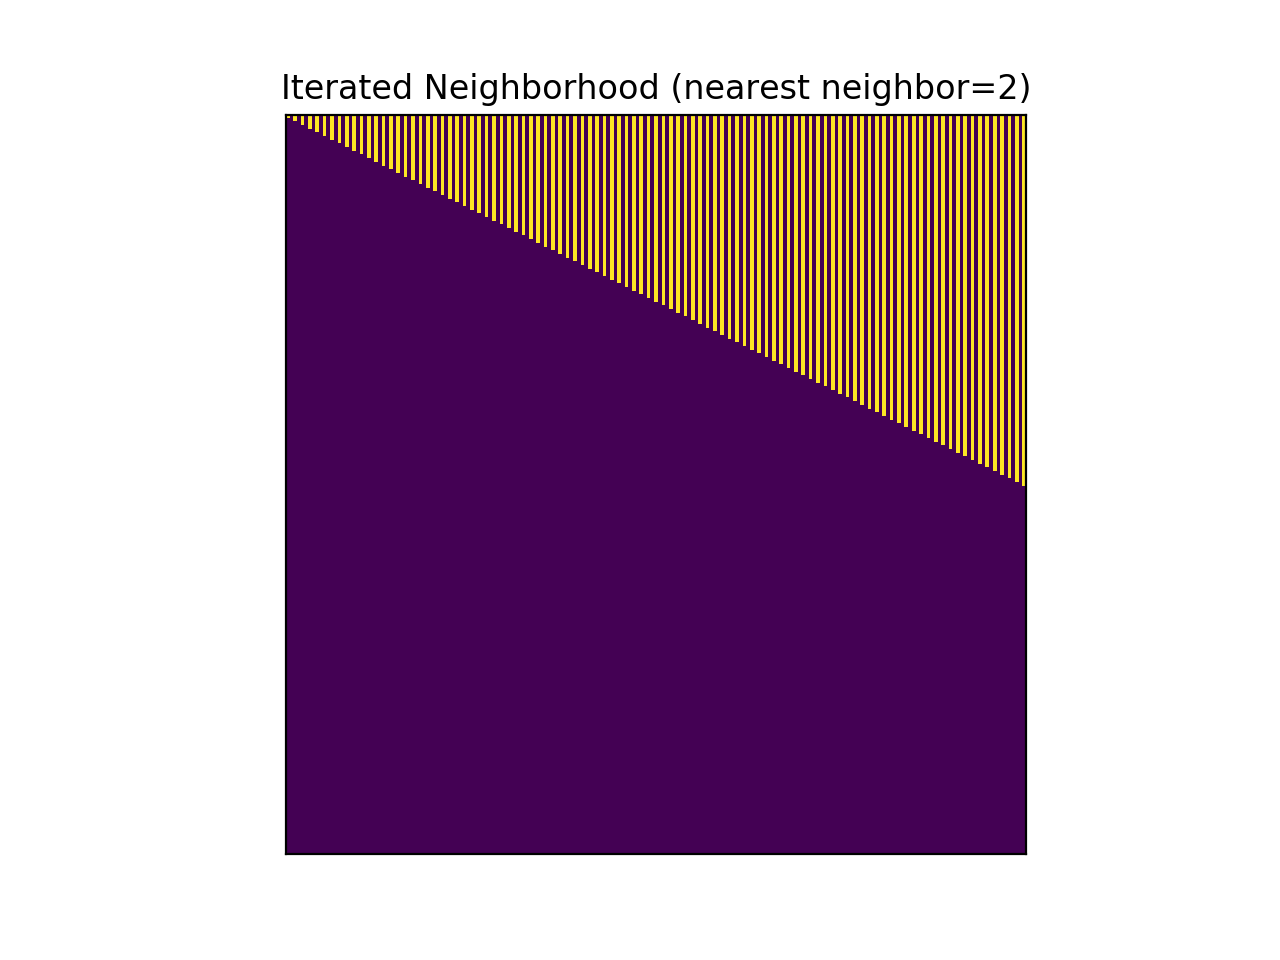

In [75]:
fig, ax = plt.subplots()
structure =   np.array([[True, False, True],
               [False, False, True],
               [False, False, False]], dtype=bool)
ax.set_title("Iterated Neighborhood (nearest neighbor=2)")
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([]);
ax.imshow(iterate_structure(structure, 100))

### Finding the Actual Peaks
What we are after are the local peaks in our data. `maximum_filter` essentially smears the local maxima over our data. Go back to look at the example you saw with `maximum_filter` to see this.

We can simply compare our data array agains these smeared maxima. Where the data matches the maxima is where our loal peaks are!

That is
```python
peaks = (data == maximum_filter(data, footprint=fp))
```

`peaks` is thus an array of `True`s (1s) wherever there is a local peak, and `False`s (0s) elsewhere. Let's write a function that takes in a 2D array of data, and returns this bindary indicator of the local peaks in the data: an array whose element is `True` wherever the datum is a local peak, and `False` otherwise. 

Use the rank-2, connectivity-2 footprint. 

Call the function `local_peaks_v1`. Note that "local" here means that we are finding peaks within 3x3 neighborhoods.

In [76]:
# SOLUTION
def local_peaks_v1(data):
    """ Find local peaks in a 2D array of data.
    
        Parameters
        ----------
        data : numpy.ndarray
        
        Returns
        -------
        Binary indicator, of the same shape as `data`. The value of
        True indicates a local peak. """
    structure =   np.array([[True, True, True],
                           [True, True, True],
                           [True, True, True]], dtype=bool)
    smear = maximum_filter(data, footprint = structure)
    return smear == data

array([[False, False, False, False],
       [False,  True, False, False],
       [False, False, False, False],
       [False, False, False, False]], dtype=bool)

Here is a function that will plot the paw prints next to the binary indicator of the local peaks.

In [71]:
def plot_compare(data, peak_finding_function):
    """ Plot the original data side-by-side with the binary indicator
        for the local peaks.
        
        Parameters
        ----------
        data : numpy.ndarray, shape=(N, H, W)
            N 2D arrays of shape (H, W). (the N paw prints)
            
        peak_finding_function : Callable[ndarray, ndarray]
            Your local-peak indicator function"""
    fig, ax = plt.subplots(nrows=len(data), ncols=2)
    for i, dat in enumerate(data):
        ax[i, 0].imshow(dat)
        ax[i, 1].imshow(peak_finding_function(dat))
    return fig, ax

Now plot a comparison to assess how well our peak-finding function works.

<IPython.core.display.Javascript object>


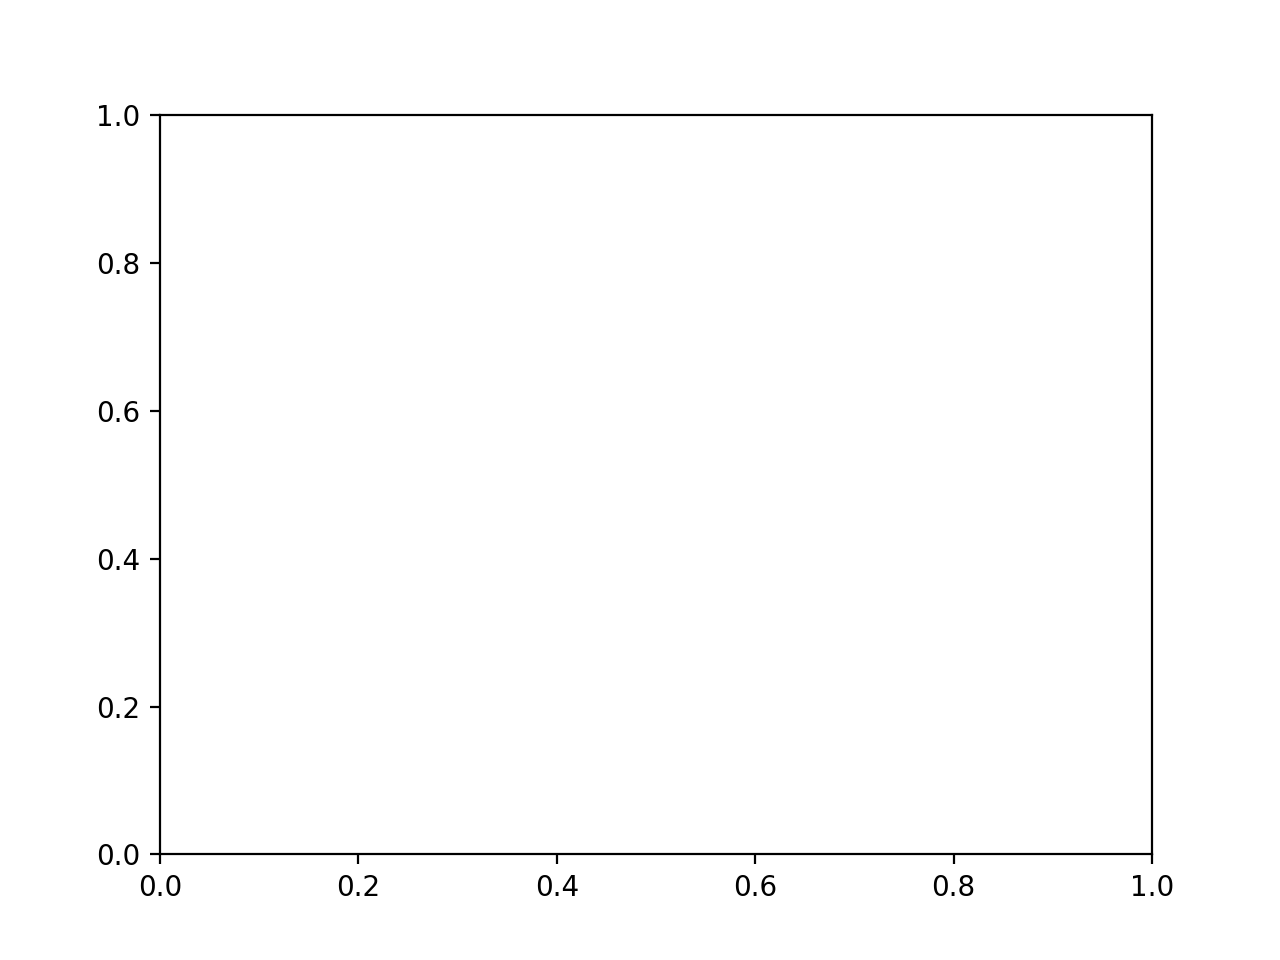

<IPython.core.display.Javascript object>


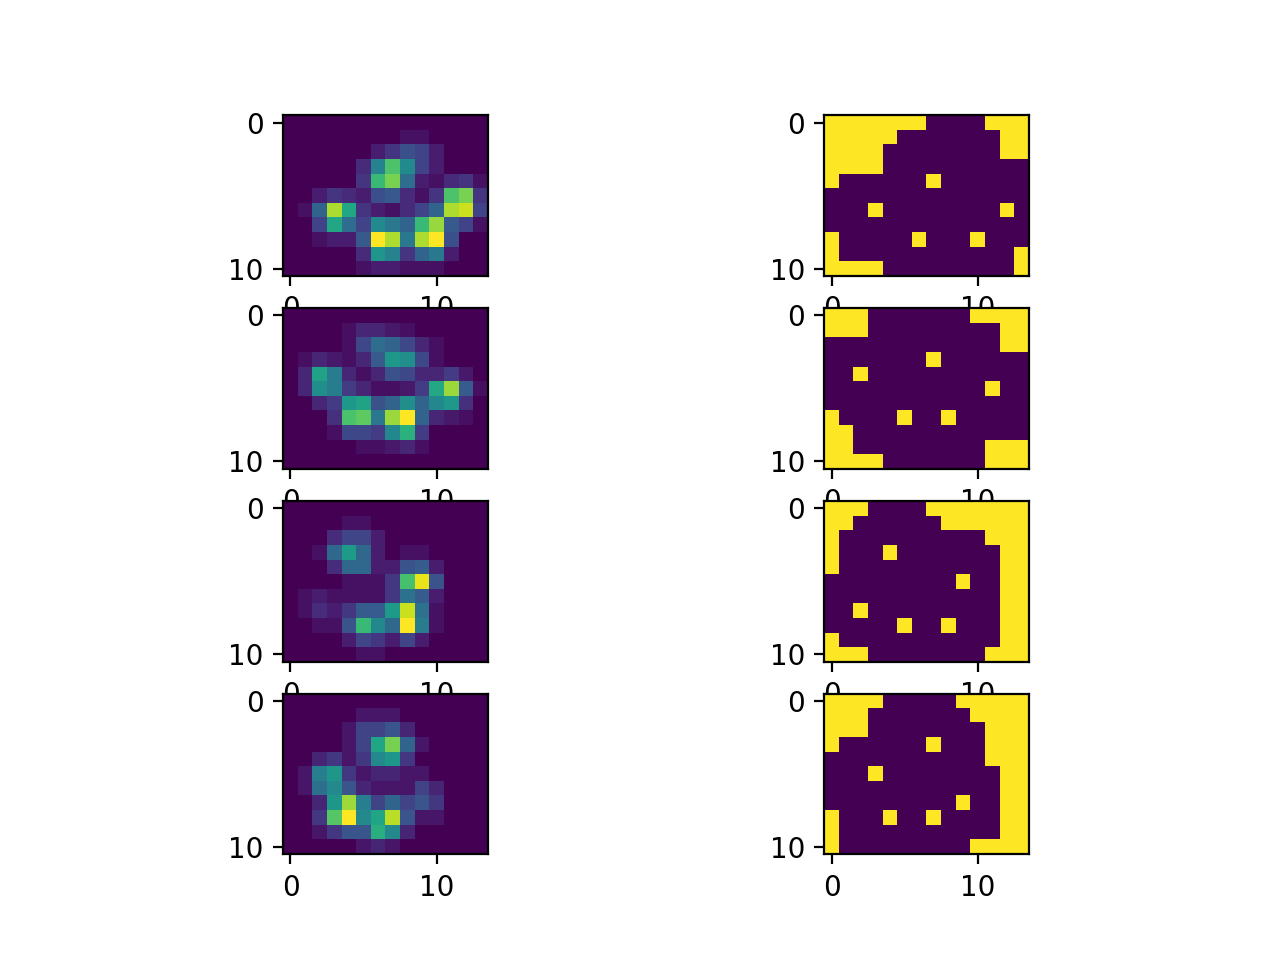

(<matplotlib.figure.Figure at 0x1146d3cf8>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x121432630>,
         <matplotlib.axes._subplots.AxesSubplot object at 0x121653128>]], dtype=object))

In [77]:
# SOLUTION


plot_compare(paws, local_peaks_v1)

What do you see in these right-column images? Are these precisely the results we are looking for? What do we need to add to our algorithm, if anything? 

Hint: what happens if a 3x3 region is all a constant value. Will this give us a false-positive detection for a "local" peak? Also, look back at the paw prints. Do these false detections overlap with certain regions of the image?

Try to think of your solution phrased as: 
 - we want points that are peak values and are *not* ???
> SOLUTION: 

Write an revised function that takes care of the issue we see above. Think of the logic functions we might want to use to combine our boolean arrays to give us the true local peaks.

In [87]:
# SOLUTION
def local_peaks_v2(data):
    """ Find local peaks in a 2D array of data.
    
        Parameters
        ----------
        data : numpy.ndarray
        
        Returns
        -------
        Binary indicator, of the same shape as `data`. The value of
        True indicates a local peak. """
    structure =   np.array([[True, True, True],
                           [True, True, True],
                           [True, True, True]], dtype=bool)
    smear = (data == maximum_filter(data, footprint = structure)) * data
    return smear > 0

Plot the performance of this revised function using `plot_compare`

<IPython.core.display.Javascript object>


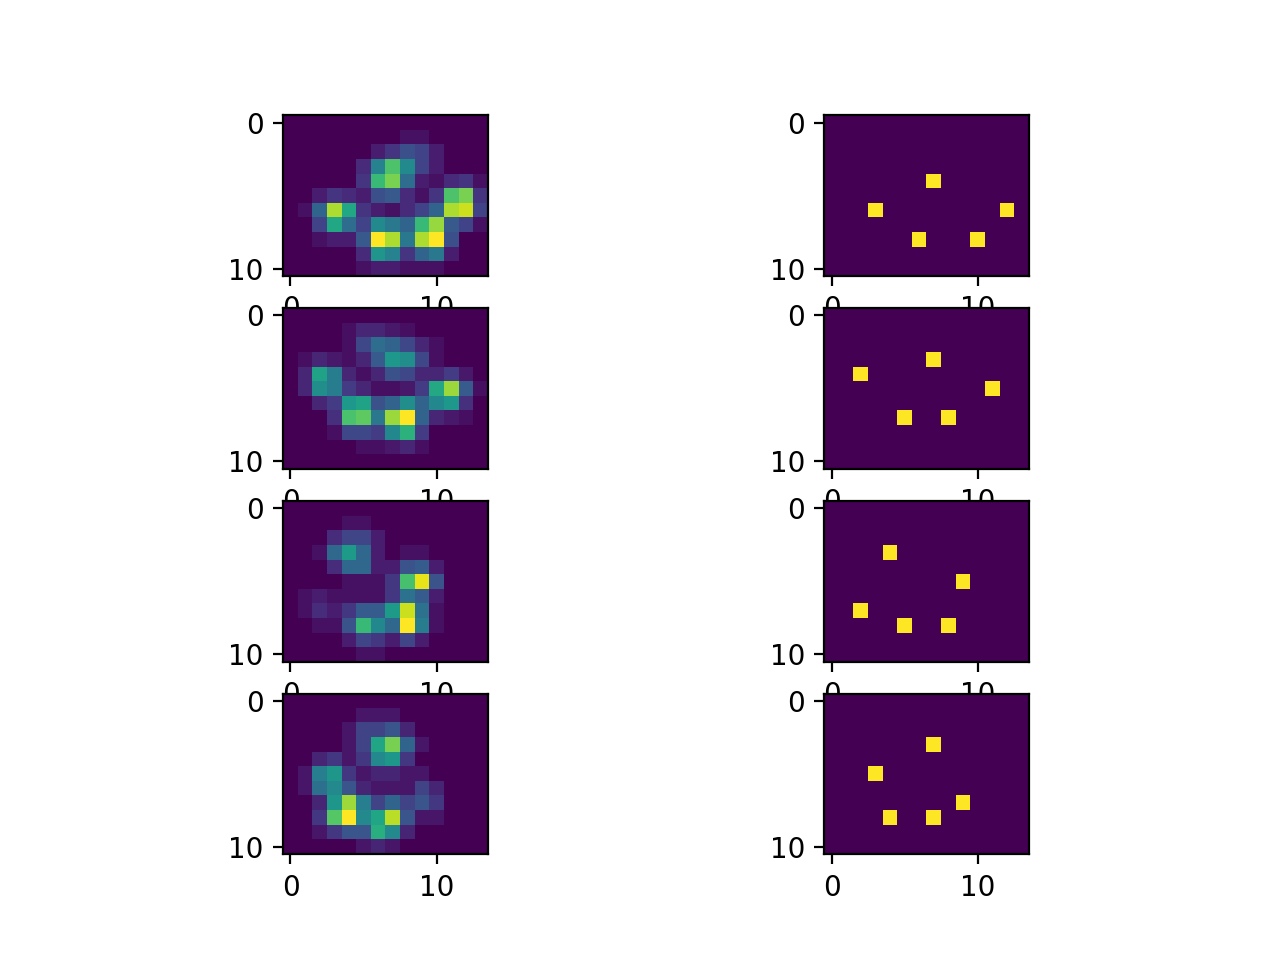

(<matplotlib.figure.Figure at 0x121178e48>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11564b908>,
         <matplotlib.axes._subplots.AxesSubplot object at 0x123489748>]], dtype=object))

In [88]:
plot_compare(paws, local_peaks_v2)